In [ ]:
%load_ext autoreload
%autoreload 2

# Group assignment: classifying brain stroke CT images using PyTorch

# 1: Task Definition


This project involves applying **supervised learning** techniques to a **multiclass classification** problem using head CT images. The goal is to develop a model capable of **predicting brain stroke type** by classifying each image into one of three categories: *no stroke*, *ischemia*, or *bleeding*.

The best performing model will be further analysed using **Explainable Artificial Intelligence** (XAI). **Gradient-weighted Class Activation Mapping** (Grad-CAM) will be applied to provide further insights into misclassified images.


# Imports and packages used

All imports necessary to properly run the notebook will be in the cell below.
All packages used can be found in the requirements.txt file, which will be handed in alongside the notebook.

In [2]:
# Standard libraries
import os
import random
import glob

# Numerical and data handling
import numpy as np
import pandas as pd

# Image handling
from PIL import Image

# PyTorch core
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

# TorchVision
import torchvision.models as models
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Progress bars
from tqdm import tqdm


# Sklearn utilities
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight
from sklearn.svm import SVC

# Model saving/loading
import joblib

# Grad-CAM
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask


## Set seed for identical results when re-run 

### Data Loading Note

Most of the code for loading the data is adapted from [this existing Kaggle notebook by Kangxun Fang](https://www.kaggle.com/code/kangxunfang/stroke-ct-with-visualization-accuracy-92).  
All code related to model training was not inspired by previous notebooks.


In [3]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)


## Data loading and preprocessing

In [4]:
# TODO: Add your own path
dataset_path = "./data/Brain_Stroke_CT_Dataset"

def load_image_paths(dataset_path):
    """Load image paths with corresponding labels from the dataset structure"""
    image_paths = []
    labels = []

    # Dictionary to map class folders to numeric labels
    class_map = {
        'Normal': 0,
        'Bleeding': 1,
        'Ischemia': 2
    }

    # Iterate through each class folder
    for class_name, label in class_map.items():
        # Get all PNG images within this class
        png_path = os.path.join(dataset_path, class_name, 'PNG')

        if os.path.exists(png_path):
            png_files = glob.glob(os.path.join(png_path, '*.png'))

            # Add each image path with its label
            for img_path in png_files:
                image_paths.append(img_path)
                labels.append(label)
        else:
            print(f"Warning: Path {png_path} does not exist")

    return image_paths, labels

In [5]:
# Get image paths and labels
image_paths, labels = load_image_paths(dataset_path)
print(f"Found {len(image_paths)} images across {len(set(labels))} classes")

# Check class distribution
class_names = ['Normal', 'Bleeding', 'Ischemia']
label_counts = pd.Series(labels).value_counts().sort_index()
print("Class distribution:")
for i, count in enumerate(label_counts):
    print(f"{class_names[i]}: {count} images")

Found 6650 images across 3 classes
Class distribution:
Normal: 4427 images
Bleeding: 1093 images
Ischemia: 1130 images


**Found 6650 images across 3 classes**

**Class distribution:**
- Normal: 4427 images  
- Bleeding: 1093 images  
- Ischemia: 1130 images

## Plot class distribution

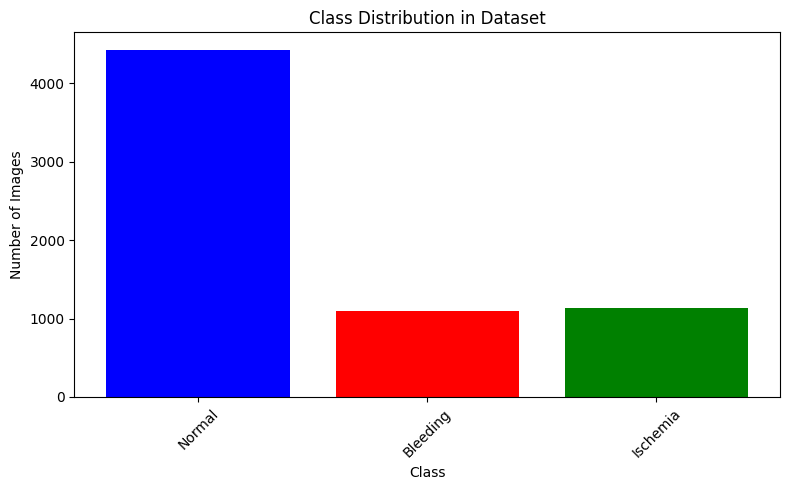

In [6]:
plt.figure(figsize=(8, 5))
plt.bar(class_names, label_counts, color=['blue', 'red', 'green'])
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution in Dataset')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Plot a few examples for data insights

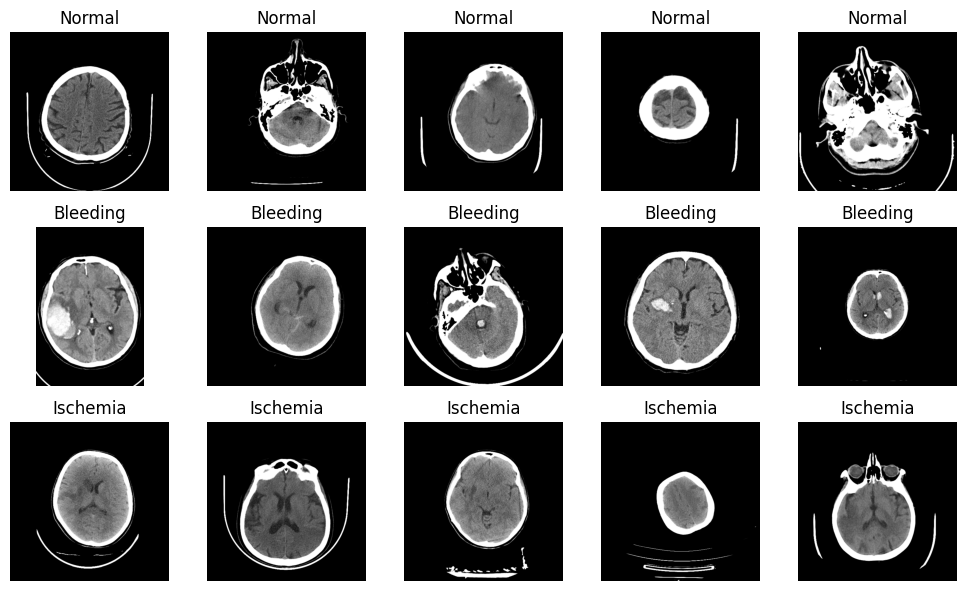

In [7]:
# Generate fixed indices once
sample_indices = {}
for i in range(3):  # 3 classes
    class_indices = [idx for idx, label in enumerate(labels) if label == i]
    sample_indices[i] = np.random.choice(class_indices, 5, replace=False)

# Updated show_samples
def show_samples(image_paths, indices_by_class):
    fig, axes = plt.subplots(3, 5, figsize=(10, 6))

    for i in range(3):
        for j, idx in enumerate(indices_by_class[i]):
            img = Image.open(image_paths[idx])
            axes[i, j].imshow(img)
            axes[i, j].set_title(class_names[i])
            axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

# Show fixed sample images
show_samples(image_paths, sample_indices)


## Split in train, test and validation sets

In [8]:
X_train, X_temp, y_train, y_temp = train_test_split(image_paths, labels, test_size=0.4, random_state=42, stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Training set: {len(X_train)} images")
print(f"Validation set: {len(X_val)} images")
print(f"Test set: {len(X_test)} images")

# print the class distribution in each set
print("\nClass distribution in training set:")
print(pd.Series(y_train).value_counts().sort_index())

print("\nClass distribution in validation set:")
print(pd.Series(y_val).value_counts().sort_index())

print("\nClass distribution in test set:")
print(pd.Series(y_test).value_counts().sort_index())

Training set: 3990 images
Validation set: 1330 images
Test set: 1330 images

Class distribution in training set:
0    2656
1     656
2     678
Name: count, dtype: int64

Class distribution in validation set:
0    885
1    219
2    226
Name: count, dtype: int64

Class distribution in test set:
0    886
1    218
2    226
Name: count, dtype: int64


# Feature creation & feature selection

We do not perform manual feature creation or selection, this is not relevant for our approach/problem.  
For the SVM, we flatten the image pixels and reduce dimensionality using PCA.  
For CNNs, relevant features are learned automatically during training through the network’s convolutional layers.

# Support Vector Machine (SVM)

We use a Support Vector Machine (SVM) as a simple **baseline model** for our image classification task.  
While SVMs are not specialised for image data, they can still perform reasonably well with flattened pixel inputs.

Later, we implement more advanced models designed for image data, in this case Convolutional Neural Networks (CNNs). We then compare the performance of these advanced models against the baseline results.


## Flatten images

In [9]:
def preprocess_images(image_paths):
    flattened = []
    for path in tqdm(image_paths, desc="Flattening images"):
        img = Image.open(path).convert("RGB")
        img_tensor = svm_transform(img)
        flattened.append(img_tensor.view(-1).numpy())
    return np.stack(flattened)

# Define your transform
svm_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(),
    transforms.ToTensor()
])

# Preprocess training data
X_train_flat = preprocess_images(X_train)
X_val_flat = preprocess_images(X_val)
X_test_flat = preprocess_images(X_test)


Flattening images: 100%|██████████| 1330/1330 [00:04<00:00, 322.55it/s]


## Small HPO

We optimise a pipeline consisting of:
- **StandardScaler**: Feature normalization. Make all features have the same scale.
- **PCA** (Principal Component Analysis): Dimensionality reduction. Reduce the number of features while keeping most of the important information.
- **SVC (RBF kernel)**: Set to handle balanced weights.

We use `GridSearchCV` with 3-fold cross-validation to **exhaustively try all combinations** of the given hyperparameters.

For each combination, the model is trained and validated 3 times using cross-validation on the **training set**.  


- `pca__n_components`: How many features to keep after PCA ([100, 150, 200]).
- `svc__C`: Controls how much the model tries to fit the training data ([1, 10, 100]). Higher values = tighter fit.
- `svc__gamma`: Controls how far the influence of each training example reaches (`'scale'`, 0.01, 0.001).  Lower values make the model focus on broader patterns, higher values make it focus more closely on individual points.

The best combination is chosen based on validation accuracy.



In [10]:
# Define pipeline
pipeline = make_pipeline(
    StandardScaler(),
    PCA(random_state=42),
    SVC(kernel='rbf', class_weight='balanced', random_state=42)
)

# Define hyperparameter grid
param_grid = {
    'pca__n_components': [100, 150, 200],
    'svc__C': [1, 10, 100],
    'svc__gamma': ['scale', 0.01, 0.001]
}

# Grid search
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

# Fit grid search
grid_search.fit(X_train_flat, y_train)

# Save best model
best_svm_model = grid_search.best_estimator_
joblib.dump(best_svm_model, "svm_pca_rbf_hpo.pkl")

# Report best parameters
best_params = grid_search.best_params_
print("Best hyperparameters found:")
print(best_params)


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best hyperparameters found:
{'pca__n_components': 150, 'svc__C': 100, 'svc__gamma': 0.001}


## Evaluating Optimised SVM with PCA



Classification Report SVM + PCA:
              precision    recall  f1-score   support

      Normal       0.92      0.98      0.95       886
    Bleeding       0.96      0.82      0.89       218
    Ischemia       0.95      0.84      0.89       226

    accuracy                           0.93      1330
   macro avg       0.94      0.88      0.91      1330
weighted avg       0.93      0.93      0.93      1330



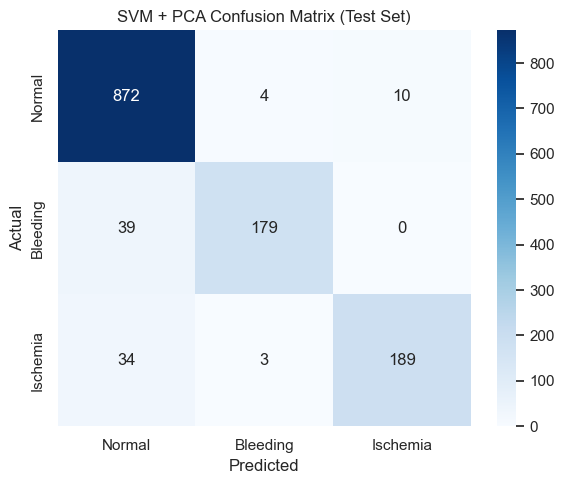

In [28]:
# Load best model
svm_clf = joblib.load("svm_pca_rbf_hpo.pkl")

# Predict on test set
y_pred = svm_clf.predict(X_test_flat)

# Evaluation
print("\nClassification Report SVM + PCA:")
print(classification_report(y_test, y_pred, target_names=["Normal", "Bleeding", "Ischemia"]))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Normal", "Bleeding", "Ischemia"],
            yticklabels=["Normal", "Bleeding", "Ischemia"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("SVM + PCA Confusion Matrix (Test Set)")
plt.tight_layout()
plt.show()

### SVM + PCA performance summary

The SVM model with PCA performs surprisingly well, achieving an overall accuracy of **93%** on the test set.  
It performs especially strongly on the **Normal** class. We will use **F1-score** as another leading metric, since it combines precision and recall into a single value. 
The SVM has achieved the following F1-scores:

- **Normal**: F1-score = **0.95**
- **Bleeding**: F1-score = **0.89**
- **Ischemia**: F1-score = **0.89**

Let's try to beat these baseline results by implementing more advanced image recognition models, like CNNs.

# Basic CNN approach

- No hyperparameter tuning (fixed architecture and learning rate)
- No data augmentation applied (only resising and normalisation)
- Custom CNN architecture with 3 convolutional layers
- Acts as a **first deep learning baseline** before optimal appraoch: ResNet18


### Check if CUDA is available

In [ ]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if torch.cuda.is_available():
    print("CUDA is available!")
    print("GPU Name:", torch.cuda.get_device_name(0))
else:
    print("Running on CPU.")

Using device: cuda
CUDA is available!
GPU Name: NVIDIA GeForce RTX 4070 Laptop GPU


## CNN model definition

In [ ]:
class StrokeCNN(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64 * 32 * 32, 128), nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

## Dataset & DataLoader

In [ ]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

class StrokeDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, self.labels[idx]

train_loader = DataLoader(StrokeDataset(X_train, y_train, transform), batch_size=16, shuffle=True)
val_loader = DataLoader(StrokeDataset(X_val, y_val, transform), batch_size=16)
test_loader = DataLoader(StrokeDataset(X_test, y_test, transform), batch_size=16)

## Training Loop

- Trains the CNN for up to 20 epochs
- Uses **CrossEntropyLoss** and the **Adam optimizer** with learning rate `1e-4`
- Applies a **ReduceLROnPlateau** scheduler to lower the learning rate when validation loss plateaus
- Implements **early stopping** based on **validation loss**, with a patience of 5 epochs to prevent overfitting
- Saves the model with the best validation loss


In [ ]:
# Initialize model, loss function, optimizer, and learning rate scheduler
model = StrokeCNN(num_classes=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.3, min_lr=1e-6)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_val_loss = float('inf')
patience, patience_counter = 5, 0

# Training loop
for epoch in range(1, 21):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch}/20"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0

    # Validation loop
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()
            val_correct += (outputs.argmax(1) == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= len(val_loader)
    val_acc = val_correct / val_total

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    scheduler.step(val_loss)
    print(f"Epoch {epoch} - "
          f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break


Epoch 1/20: 100%|██████████| 250/250 [00:25<00:00,  9.91it/s]


Epoch 1 - Train Loss: 0.8009, Acc: 0.6762 | Val Loss: 0.7152, Acc: 0.7195


Epoch 2/20: 100%|██████████| 250/250 [00:26<00:00,  9.45it/s]


Epoch 2 - Train Loss: 0.6578, Acc: 0.7298 | Val Loss: 0.6652, Acc: 0.7353


Epoch 3/20: 100%|██████████| 250/250 [00:25<00:00,  9.84it/s]


Epoch 3 - Train Loss: 0.5592, Acc: 0.7815 | Val Loss: 0.5776, Acc: 0.7902


Epoch 4/20: 100%|██████████| 250/250 [00:25<00:00,  9.70it/s]


Epoch 4 - Train Loss: 0.4792, Acc: 0.8133 | Val Loss: 0.5890, Acc: 0.7782


Epoch 5/20: 100%|██████████| 250/250 [00:25<00:00,  9.68it/s]


Epoch 5 - Train Loss: 0.4079, Acc: 0.8446 | Val Loss: 0.5218, Acc: 0.8150


Epoch 6/20: 100%|██████████| 250/250 [00:25<00:00,  9.79it/s]


Epoch 6 - Train Loss: 0.3207, Acc: 0.8845 | Val Loss: 0.4850, Acc: 0.8436


Epoch 7/20: 100%|██████████| 250/250 [00:25<00:00,  9.65it/s]


Epoch 7 - Train Loss: 0.2575, Acc: 0.9093 | Val Loss: 0.4777, Acc: 0.8466


Epoch 8/20: 100%|██████████| 250/250 [00:25<00:00,  9.72it/s]


Epoch 8 - Train Loss: 0.1918, Acc: 0.9376 | Val Loss: 0.4749, Acc: 0.8632


Epoch 9/20: 100%|██████████| 250/250 [00:26<00:00,  9.49it/s]


Epoch 9 - Train Loss: 0.1438, Acc: 0.9541 | Val Loss: 0.5205, Acc: 0.8699


Epoch 10/20: 100%|██████████| 250/250 [00:26<00:00,  9.50it/s]


Epoch 10 - Train Loss: 0.1125, Acc: 0.9629 | Val Loss: 0.4600, Acc: 0.8774


Epoch 11/20: 100%|██████████| 250/250 [00:26<00:00,  9.58it/s]


Epoch 11 - Train Loss: 0.0791, Acc: 0.9767 | Val Loss: 0.6807, Acc: 0.8549


Epoch 12/20: 100%|██████████| 250/250 [00:25<00:00,  9.82it/s]


Epoch 12 - Train Loss: 0.0617, Acc: 0.9815 | Val Loss: 0.5255, Acc: 0.8910


Epoch 13/20: 100%|██████████| 250/250 [00:25<00:00,  9.73it/s]


Epoch 13 - Train Loss: 0.0406, Acc: 0.9895 | Val Loss: 0.5235, Acc: 0.8917


Epoch 14/20: 100%|██████████| 250/250 [00:25<00:00,  9.77it/s]


Epoch 14 - Train Loss: 0.0192, Acc: 0.9977 | Val Loss: 0.5496, Acc: 0.9015


Epoch 15/20: 100%|██████████| 250/250 [00:25<00:00,  9.68it/s]


Epoch 15 - Train Loss: 0.0137, Acc: 0.9987 | Val Loss: 0.5732, Acc: 0.8977
Early stopping at epoch 15


## Plot training vs. validation performance 

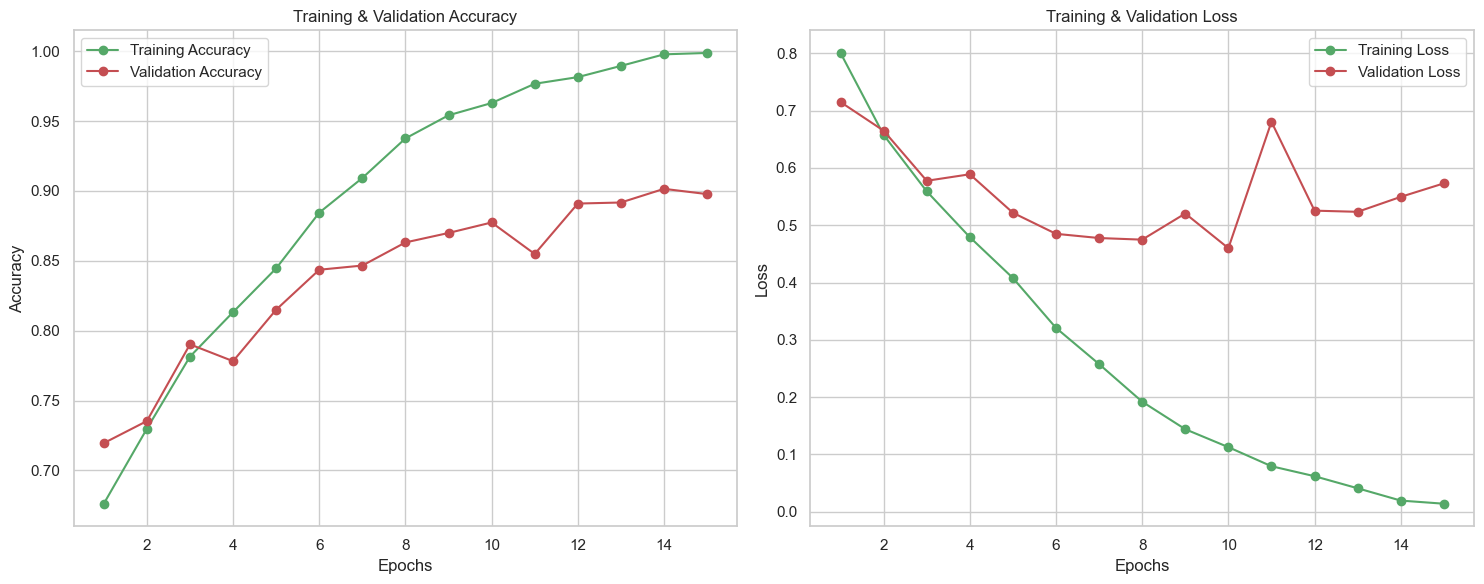

In [16]:
sns.set(style='whitegrid')

epochs = range(1, len(train_accuracies) + 1)

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Accuracy plot
ax[0].plot(epochs, train_accuracies, 'go-', label='Training Accuracy')
ax[0].plot(epochs, val_accuracies, 'ro-', label='Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

# Loss plot
ax[1].plot(epochs, train_losses, 'g-o', label='Training Loss')
ax[1].plot(epochs, val_losses, 'r-o', label='Validation Loss')
ax[1].set_title('Training & Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()

plt.tight_layout()
plt.show()


The training accuracy continues to improve while the training loss steadily decreases, showcasing that the model is learning the training data well.

However, the validation accuracy plateaus and the validation loss even increases, suggesting the model begins to **overfit** after approximately epoch 10.


## Evaluate the model

C:\Users\stijn\AppData\Local\Temp\ipykernel_29804\1201590935.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pt"))


Classification Report:

              precision    recall  f1-score   support

      Normal       0.91      0.94      0.93       886
    Bleeding       0.85      0.70      0.77       218
    Ischemia       0.77      0.80      0.79       226

    accuracy                           0.88      1330
   macro avg       0.84      0.82      0.83      1330
weighted avg       0.88      0.88      0.88      1330



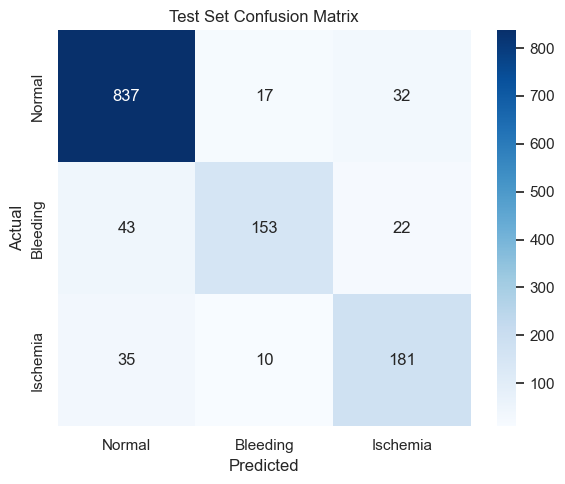

In [17]:
# Load best model
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

# Collect predictions
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification report
print("Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Test Set Confusion Matrix")
plt.tight_layout()
plt.show()


### Basic CNN performance summary

The basic CNN model reaches an overall accuracy of **88%** on the test set.  
While it learns the training data well, validation performance begins to plateau after around epoch 10, showing **overfitting**.

We again focus on **F1-score** to evaluate performance across classes:

- **Normal**: F1-score = **0.93**
- **Bleeding**: F1-score = **0.77**
- **Ischemia**: F1-score = **0.79**

Compared to the SVM + PCA baseline, this CNN performs **worse across all metrics**, including overall accuracy and F1-scores across all classes.

In the next step, we implement a more advanced CNN architecture: **ResNet18**.


# ResNet18

In this approach, we aim to improve performance by using a more advanced CNN architecture:

- Uses a **pretrained ResNet18**, a pretrained CNN that is 18 layers deep
- We apply **data augmentation** to improve generalisation (random flips, rotations, colour jitter). This helps the model perform better by exposing it to slightly altered versions of the training images, so it has more data to train on.
- We use **class weights** so that the model pays more attention to underrepresented classes during training
- We use **learning rate scheduling** to reduce the learning rate when validation performance stops improving
- We use **early stopping**, based on the **validation accuracy**, with a patience of 10 epochs to prevent overfitting. We did not use validation loss here, since validation accuracy seems to return the best results on the test set. Validation accuracy also serves as a good indicator of how well the model is likely to perform on the test set.
- In general, we trained the model for more epochs and used a higher patience compared to the earlier approach (basic CNN), allowing the model more time to reach optimal performance.



## Transforms and model definition

In [ ]:
# Updated transforms with augmentation
train_transform_augmented = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor()
])
val_test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Define CNN with pretrained ResNet18
class FineTunedResNet(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.base_model = models.resnet18(pretrained=True)
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, num_classes)

    def forward(self, x):
        return self.base_model(x)

model = FineTunedResNet().to(device)

# Re-define datasets using the correct transforms
train_dataset = StrokeDataset(X_train, y_train, transform=train_transform_augmented)
val_dataset = StrokeDataset(X_val, y_val, transform=val_test_transform)
test_dataset = StrokeDataset(X_test, y_test, transform=val_test_transform)


c:\Users\stijn\Desktop\Informatica\Jaar_3\DS_HONOURS\myenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\stijn\Desktop\Informatica\Jaar_3\DS_HONOURS\myenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Loss function, optmizer, scheduler & DataLoaders

In [ ]:
# Set class weights for imbalanced classes
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Loss, optimizer, scheduler
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.3, min_lr=1e-6)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

## Training loop

In [23]:
# Variables for early stopping and best model tracking
best_val_acc = 0.0
patience = 10
patience_counter = 0
num_epochs = 50

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Training loop for fine-tuning
for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    model.eval()
    val_loss, val_correct = 0.0, 0

    # Validation loop
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()
            val_correct += (outputs.argmax(1) == labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = val_correct / len(val_dataset)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    scheduler.step(val_acc)
    current_lr = optimizer.param_groups[0]['lr']

    print(f"Epoch {epoch}/{num_epochs} - "
          f"loss: {train_loss:.4f} - accuracy: {train_acc:.4f} - "
          f"val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.4f} - lr: {current_lr:.1e}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), "best_model_finetuned.pt")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break


Epoch 1/50: 100%|██████████| 125/125 [00:25<00:00,  4.96it/s]


Epoch 1/50 - loss: 0.6647 - accuracy: 0.7271 - val_loss: 0.6217 - val_accuracy: 0.8541 - lr: 1.0e-04


Epoch 2/50: 100%|██████████| 125/125 [00:25<00:00,  4.94it/s]


Epoch 2/50 - loss: 0.4150 - accuracy: 0.8434 - val_loss: 0.5125 - val_accuracy: 0.8842 - lr: 1.0e-04


Epoch 3/50: 100%|██████████| 125/125 [00:25<00:00,  4.93it/s]


Epoch 3/50 - loss: 0.3341 - accuracy: 0.8784 - val_loss: 0.4948 - val_accuracy: 0.8391 - lr: 1.0e-04


Epoch 4/50: 100%|██████████| 125/125 [00:25<00:00,  4.97it/s]


Epoch 4/50 - loss: 0.2487 - accuracy: 0.9095 - val_loss: 0.3752 - val_accuracy: 0.8271 - lr: 1.0e-04


Epoch 5/50: 100%|██████████| 125/125 [00:24<00:00,  5.05it/s]


Epoch 5/50 - loss: 0.1890 - accuracy: 0.9261 - val_loss: 0.3208 - val_accuracy: 0.8669 - lr: 1.0e-04


Epoch 6/50: 100%|██████████| 125/125 [00:24<00:00,  5.08it/s]


Epoch 6/50 - loss: 0.1482 - accuracy: 0.9414 - val_loss: 0.3037 - val_accuracy: 0.9286 - lr: 1.0e-04


Epoch 7/50: 100%|██████████| 125/125 [00:24<00:00,  5.07it/s]


Epoch 7/50 - loss: 0.1601 - accuracy: 0.9386 - val_loss: 0.3825 - val_accuracy: 0.9023 - lr: 1.0e-04


Epoch 8/50: 100%|██████████| 125/125 [00:25<00:00,  4.98it/s]


Epoch 8/50 - loss: 0.1252 - accuracy: 0.9549 - val_loss: 0.4693 - val_accuracy: 0.8880 - lr: 1.0e-04


Epoch 9/50: 100%|██████████| 125/125 [00:24<00:00,  5.08it/s]


Epoch 9/50 - loss: 0.1162 - accuracy: 0.9561 - val_loss: 0.2946 - val_accuracy: 0.9383 - lr: 1.0e-04


Epoch 10/50: 100%|██████████| 125/125 [00:24<00:00,  5.12it/s]


Epoch 10/50 - loss: 0.1075 - accuracy: 0.9589 - val_loss: 0.4009 - val_accuracy: 0.9045 - lr: 1.0e-04


Epoch 11/50: 100%|██████████| 125/125 [00:24<00:00,  5.02it/s]


Epoch 11/50 - loss: 0.0940 - accuracy: 0.9669 - val_loss: 0.3631 - val_accuracy: 0.9271 - lr: 1.0e-04


Epoch 12/50: 100%|██████████| 125/125 [00:24<00:00,  5.12it/s]


Epoch 12/50 - loss: 0.0772 - accuracy: 0.9699 - val_loss: 0.3626 - val_accuracy: 0.8812 - lr: 1.0e-04


Epoch 13/50: 100%|██████████| 125/125 [00:25<00:00,  4.90it/s]


Epoch 13/50 - loss: 0.0621 - accuracy: 0.9757 - val_loss: 0.2570 - val_accuracy: 0.9541 - lr: 1.0e-04


Epoch 14/50: 100%|██████████| 125/125 [00:25<00:00,  4.88it/s]


Epoch 14/50 - loss: 0.0495 - accuracy: 0.9822 - val_loss: 0.3598 - val_accuracy: 0.9414 - lr: 1.0e-04


Epoch 15/50: 100%|██████████| 125/125 [00:24<00:00,  5.06it/s]


Epoch 15/50 - loss: 0.0850 - accuracy: 0.9689 - val_loss: 0.3394 - val_accuracy: 0.9383 - lr: 1.0e-04


Epoch 16/50: 100%|██████████| 125/125 [00:24<00:00,  5.01it/s]


Epoch 16/50 - loss: 0.0575 - accuracy: 0.9782 - val_loss: 0.3861 - val_accuracy: 0.8519 - lr: 1.0e-04


Epoch 17/50: 100%|██████████| 125/125 [00:24<00:00,  5.01it/s]


Epoch 17/50 - loss: 0.0464 - accuracy: 0.9825 - val_loss: 0.3500 - val_accuracy: 0.9406 - lr: 3.0e-05


Epoch 18/50: 100%|██████████| 125/125 [00:25<00:00,  4.92it/s]


Epoch 18/50 - loss: 0.0451 - accuracy: 0.9842 - val_loss: 0.2346 - val_accuracy: 0.9519 - lr: 3.0e-05


Epoch 19/50: 100%|██████████| 125/125 [00:25<00:00,  4.92it/s]


Epoch 19/50 - loss: 0.0184 - accuracy: 0.9950 - val_loss: 0.2110 - val_accuracy: 0.9466 - lr: 3.0e-05


Epoch 20/50: 100%|██████████| 125/125 [00:24<00:00,  5.17it/s]


Epoch 20/50 - loss: 0.0172 - accuracy: 0.9947 - val_loss: 0.2456 - val_accuracy: 0.9504 - lr: 3.0e-05


Epoch 21/50: 100%|██████████| 125/125 [00:25<00:00,  4.95it/s]


Epoch 21/50 - loss: 0.0135 - accuracy: 0.9955 - val_loss: 0.2178 - val_accuracy: 0.9489 - lr: 9.0e-06


Epoch 22/50: 100%|██████████| 125/125 [00:25<00:00,  4.87it/s]


Epoch 22/50 - loss: 0.0150 - accuracy: 0.9952 - val_loss: 0.2419 - val_accuracy: 0.9579 - lr: 9.0e-06


Epoch 23/50: 100%|██████████| 125/125 [00:25<00:00,  4.85it/s]


Epoch 23/50 - loss: 0.0137 - accuracy: 0.9960 - val_loss: 0.2289 - val_accuracy: 0.9534 - lr: 9.0e-06


Epoch 24/50: 100%|██████████| 125/125 [00:25<00:00,  4.95it/s]


Epoch 24/50 - loss: 0.0081 - accuracy: 0.9985 - val_loss: 0.2562 - val_accuracy: 0.9571 - lr: 9.0e-06


Epoch 25/50: 100%|██████████| 125/125 [00:24<00:00,  5.01it/s]


Epoch 25/50 - loss: 0.0078 - accuracy: 0.9970 - val_loss: 0.2293 - val_accuracy: 0.9586 - lr: 9.0e-06


Epoch 26/50: 100%|██████████| 125/125 [00:25<00:00,  4.89it/s]


Epoch 26/50 - loss: 0.0083 - accuracy: 0.9985 - val_loss: 0.2384 - val_accuracy: 0.9556 - lr: 9.0e-06


Epoch 27/50: 100%|██████████| 125/125 [00:25<00:00,  4.91it/s]


Epoch 27/50 - loss: 0.0076 - accuracy: 0.9980 - val_loss: 0.2471 - val_accuracy: 0.9564 - lr: 9.0e-06


Epoch 28/50: 100%|██████████| 125/125 [00:24<00:00,  5.08it/s]


Epoch 28/50 - loss: 0.0077 - accuracy: 0.9980 - val_loss: 0.2319 - val_accuracy: 0.9579 - lr: 9.0e-06


Epoch 29/50: 100%|██████████| 125/125 [00:25<00:00,  4.96it/s]


Epoch 29/50 - loss: 0.0072 - accuracy: 0.9977 - val_loss: 0.2221 - val_accuracy: 0.9541 - lr: 2.7e-06


Epoch 30/50: 100%|██████████| 125/125 [00:25<00:00,  4.98it/s]


Epoch 30/50 - loss: 0.0096 - accuracy: 0.9982 - val_loss: 0.2155 - val_accuracy: 0.9534 - lr: 2.7e-06


Epoch 31/50: 100%|██████████| 125/125 [00:24<00:00,  5.01it/s]


Epoch 31/50 - loss: 0.0053 - accuracy: 0.9987 - val_loss: 0.2461 - val_accuracy: 0.9549 - lr: 2.7e-06


Epoch 32/50: 100%|██████████| 125/125 [00:25<00:00,  4.87it/s]


Epoch 32/50 - loss: 0.0073 - accuracy: 0.9982 - val_loss: 0.2255 - val_accuracy: 0.9556 - lr: 2.7e-06


Epoch 33/50: 100%|██████████| 125/125 [00:24<00:00,  5.15it/s]


Epoch 33/50 - loss: 0.0085 - accuracy: 0.9972 - val_loss: 0.2168 - val_accuracy: 0.9564 - lr: 1.0e-06


Epoch 34/50: 100%|██████████| 125/125 [00:25<00:00,  4.87it/s]


Epoch 34/50 - loss: 0.0073 - accuracy: 0.9982 - val_loss: 0.2571 - val_accuracy: 0.9609 - lr: 1.0e-06


Epoch 35/50: 100%|██████████| 125/125 [00:25<00:00,  4.91it/s]


Epoch 35/50 - loss: 0.0057 - accuracy: 0.9990 - val_loss: 0.2358 - val_accuracy: 0.9564 - lr: 1.0e-06


Epoch 36/50: 100%|██████████| 125/125 [00:25<00:00,  4.87it/s]


Epoch 36/50 - loss: 0.0061 - accuracy: 0.9987 - val_loss: 0.2387 - val_accuracy: 0.9579 - lr: 1.0e-06


Epoch 37/50: 100%|██████████| 125/125 [00:25<00:00,  4.86it/s]


Epoch 37/50 - loss: 0.0085 - accuracy: 0.9972 - val_loss: 0.2452 - val_accuracy: 0.9594 - lr: 1.0e-06


Epoch 38/50: 100%|██████████| 125/125 [00:25<00:00,  4.82it/s]


Epoch 38/50 - loss: 0.0069 - accuracy: 0.9987 - val_loss: 0.2302 - val_accuracy: 0.9564 - lr: 1.0e-06


Epoch 39/50: 100%|██████████| 125/125 [00:26<00:00,  4.78it/s]


Epoch 39/50 - loss: 0.0064 - accuracy: 0.9987 - val_loss: 0.2358 - val_accuracy: 0.9579 - lr: 1.0e-06


Epoch 40/50: 100%|██████████| 125/125 [00:25<00:00,  4.85it/s]


Epoch 40/50 - loss: 0.0052 - accuracy: 0.9995 - val_loss: 0.2162 - val_accuracy: 0.9564 - lr: 1.0e-06


Epoch 41/50: 100%|██████████| 125/125 [00:25<00:00,  4.85it/s]


Epoch 41/50 - loss: 0.0084 - accuracy: 0.9982 - val_loss: 0.2314 - val_accuracy: 0.9602 - lr: 1.0e-06


Epoch 42/50: 100%|██████████| 125/125 [00:25<00:00,  4.85it/s]


Epoch 42/50 - loss: 0.0063 - accuracy: 0.9987 - val_loss: 0.2302 - val_accuracy: 0.9586 - lr: 1.0e-06


Epoch 43/50: 100%|██████████| 125/125 [00:25<00:00,  4.85it/s]


Epoch 43/50 - loss: 0.0066 - accuracy: 0.9992 - val_loss: 0.2261 - val_accuracy: 0.9571 - lr: 1.0e-06


Epoch 44/50: 100%|██████████| 125/125 [00:26<00:00,  4.76it/s]


Epoch 44/50 - loss: 0.0065 - accuracy: 0.9980 - val_loss: 0.2346 - val_accuracy: 0.9586 - lr: 1.0e-06
Early stopping at epoch 44


## Plot training vs. validation performance 

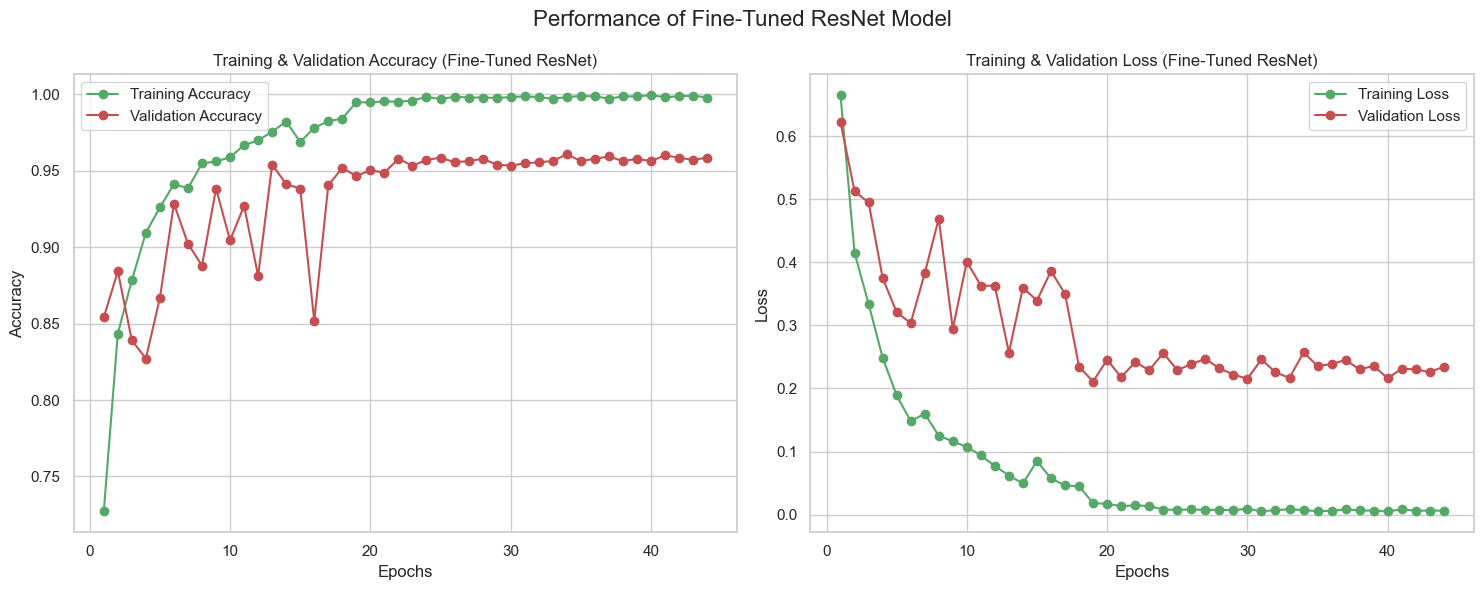

In [24]:
sns.set(style='whitegrid')

epochs = range(1, len(train_accuracies) + 1)

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

#  Accuracy Plot
ax[0].plot(epochs, train_accuracies, 'go-', label='Training Accuracy')
ax[0].plot(epochs, val_accuracies, 'ro-', label='Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy (Fine-Tuned ResNet)')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

#  Loss Plot
ax[1].plot(epochs, train_losses, 'g-o', label='Training Loss')
ax[1].plot(epochs, val_losses, 'r-o', label='Validation Loss')
ax[1].set_title('Training & Validation Loss (Fine-Tuned ResNet)')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()

plt.suptitle("Performance of Fine-Tuned ResNet Model", fontsize=16)
plt.tight_layout()
plt.show()

The training accuracy quickly reaches 99-100%, and training loss drops to nearly zero: model fits the training data perfectly.

Validation accuracy remains high and stable (~96%). Validation loss fluctuates slightly, but is stable (~0.20-0.25%).

This indicates some **very minor overfitting**, but the model's stability is very strong.

## Evaluate the model

c:\Users\stijn\Desktop\Informatica\Jaar_3\DS_HONOURS\myenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\stijn\Desktop\Informatica\Jaar_3\DS_HONOURS\myenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\stijn\AppData\Local\Temp\ipykernel_29804\3704466641.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during

Classification Report (Fine-Tuned ResNet):

              precision    recall  f1-score   support

      Normal       0.98      0.99      0.98       886
    Bleeding       0.97      0.93      0.95       218
    Ischemia       0.95      0.92      0.94       226

    accuracy                           0.97      1330
   macro avg       0.96      0.95      0.96      1330
weighted avg       0.97      0.97      0.97      1330



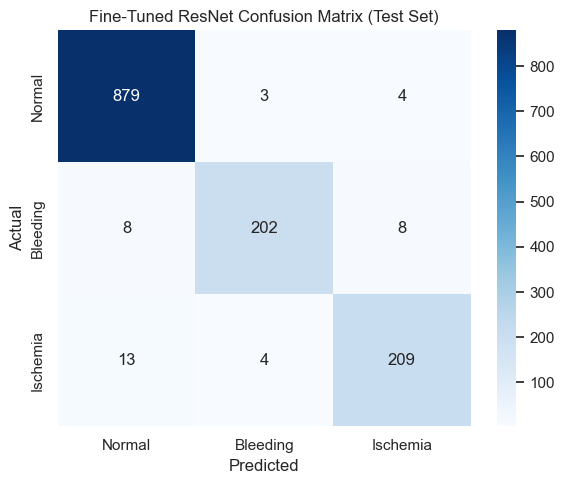

In [25]:
#  Load best fine-tuned ResNet model
model = FineTunedResNet().to(device)
model.load_state_dict(torch.load("best_model_finetuned.pt"))
model.eval()

#  Collect predictions on test set
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

#  Classification report
print("Classification Report (Fine-Tuned ResNet):\n")
print(classification_report(all_labels, all_preds, target_names=class_names))

#  Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Fine-Tuned ResNet Confusion Matrix (Test Set)")
plt.tight_layout()
plt.show()


### ResNet18 performance summary

The fine-tuned ResNet18 achieves an impressive overall accuracy of **97%** on the test set.  

We again focus on **F1-score** to assess performance per class:

- **Normal**: F1-score = **0.98**
- **Bleeding**: F1-score = **0.95**
- **Ischemia**: F1-score = **0.94**

This model clearly outperforms both the SVM and basic CNN approaches across **all metrics**, including overall accuracy and per-class F1-scores.


# XAI: Grad-CAM

For our best-performing model (ResNet18), we apply **Grad-CAM** to gather insights into what areas the model focuses on when making predictions.


This helps us understand **why certain misclassifications occur** and helps us determine if the model is looking ath the **relevant regions** when making decisions.



In [26]:
def plot_structured_gradcam_grid(model, test_loader, class_names, target_layer="base_model.layer4", num_each=2):
    model.eval()
    cam_extractor = GradCAM(model, target_layer=target_layer)

    num_classes = len(class_names)

    # Structure: {(true, pred): [img]}
    collected = {(t, p): [] for t in range(num_classes) for p in range(num_classes)}

    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(1)

        for img, true, pred in zip(images, labels, preds):
            true_class = true.item()
            pred_class = pred.item()

            key = (true_class, pred_class)
            if len(collected[key]) < num_each:
                img = img.unsqueeze(0).requires_grad_()
                out = model(img)
                cam = cam_extractor(pred_class, out)

                img_pil = to_pil_image(img.squeeze(0).cpu())
                heatmap_pil = to_pil_image(cam[0].cpu(), mode='F')
                overlay = overlay_mask(img_pil, heatmap_pil, alpha=0.5)

                title = f"T={class_names[true_class]}\nP={class_names[pred_class]}"
                collected[key].append((overlay, title))

        #  Stop early only if ALL desired (TPs + misclasses) are filled
        if all(len(v) >= num_each for v in collected.values()):
            break

    #  Prepare structured layout: 3 rows (TPs, misclass1, misclass2), 6 cols
    row_defs = [
        [(0, 0), (1, 1), (2, 2)],  # TPs
        [(0, 1), (1, 0), (2, 0)],  # misclassified as Normal
        [(0, 2), (1, 2), (2, 1)],  # misclassified as Ischemia/Bleeding
    ]

    fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(18, 9))

    for row_idx, pairs in enumerate(row_defs):
        for col_idx, (t, p) in enumerate(pairs):
            for i in range(num_each):
                ax = axes[row_idx][col_idx * num_each + i]
                if (t, p) in collected and len(collected[(t, p)]) > i:
                    overlay, title = collected[(t, p)][i]
                    ax.imshow(overlay)
                    ax.set_title(title, fontsize=8)
                else:
                    ax.set_title(f"Missing: T={t}, P={p}", fontsize=8)
                ax.axis('off')

    plt.suptitle("Grad-CAM: Top = TP, Rows 2-3 = Misclassifications", fontsize=16)
    plt.tight_layout()
    plt.show()


## Show results for our best model: best_model_finetuned

c:\Users\stijn\Desktop\Informatica\Jaar_3\DS_HONOURS\myenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\stijn\Desktop\Informatica\Jaar_3\DS_HONOURS\myenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\stijn\AppData\Local\Temp\ipykernel_29804\3234703192.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during

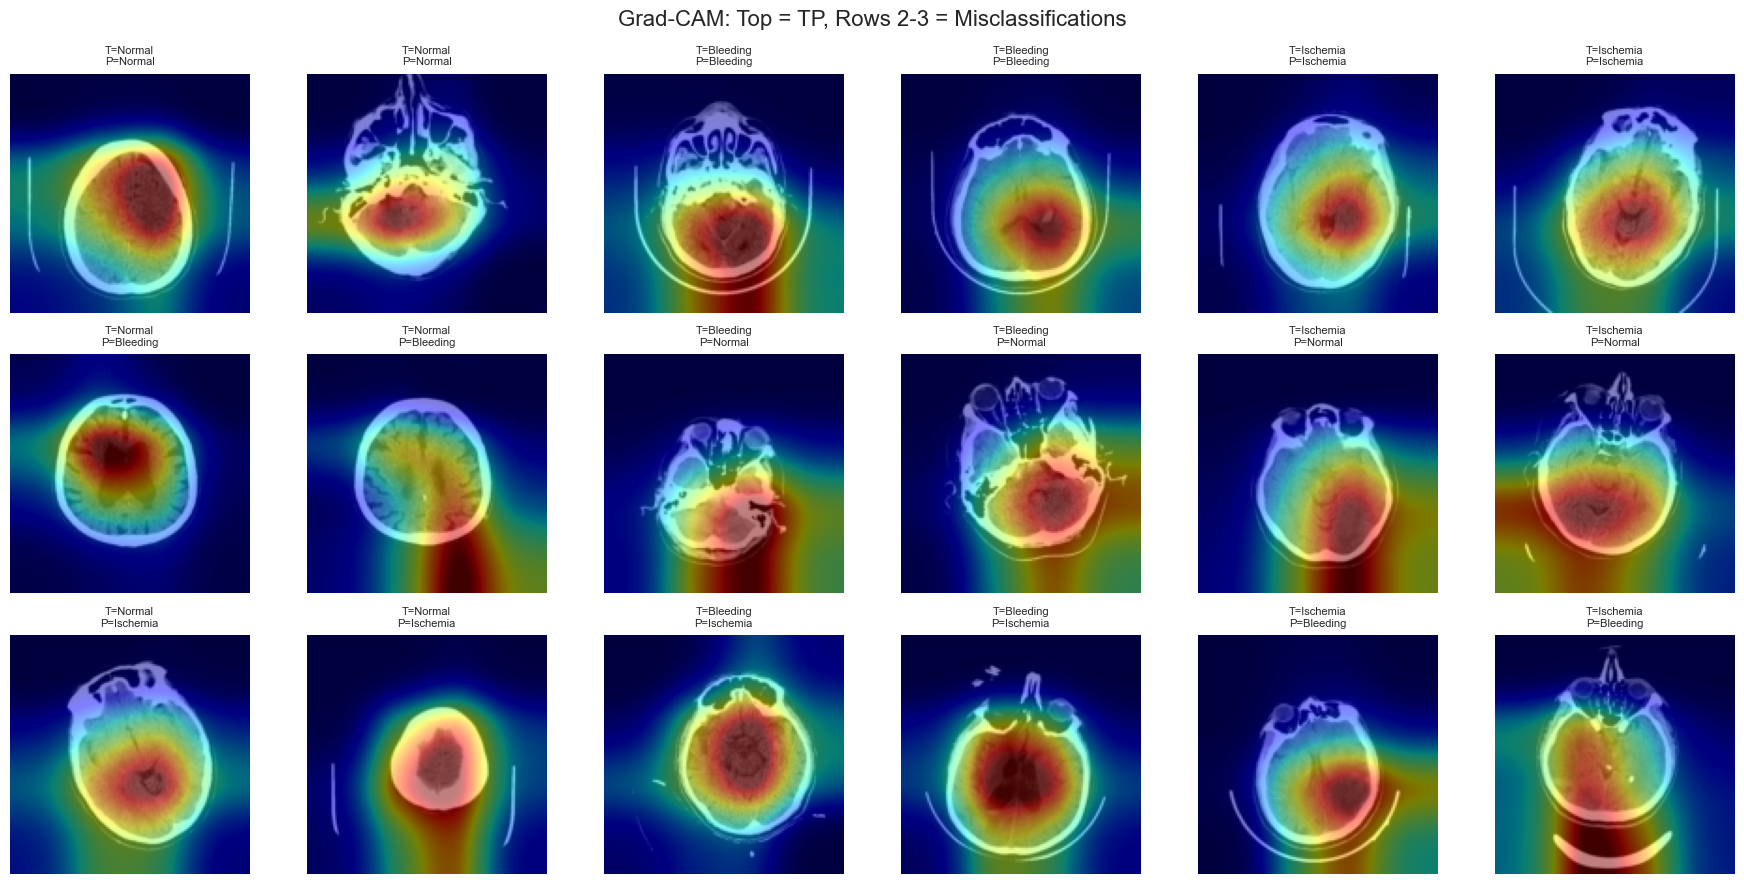

In [27]:
model = FineTunedResNet().to(device)
model.load_state_dict(torch.load("best_model_finetuned.pt"))
model.eval()

plot_structured_gradcam_grid(model, test_loader, class_names, target_layer="base_model.layer4", num_each=2)


### Grad-CAM insights

In the **top row (true positives)**, the model's attention is **sharply focused** on relevant regions.


In the **misclassified examples (rows 2–3)**, attention appears more **too broad**, highlighting less relevant regions as well. 

